In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [20]:
df = pd.read_csv(r"G:\Uppsala Docs\period5&6\ProcessedData\2015-2019_sensorData.csv")

print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450646 entries, 0 to 450645
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             450646 non-null  int64  
 1   Start                  450646 non-null  object 
 2   Stop                   450646 non-null  object 
 3   Station Name           450646 non-null  object 
 4   NO2                    445087 non-null  float64
 5   NOX as NO2             445450 non-null  float64
 6   PM2.5                  183966 non-null  float64
 7   CO                     253349 non-null  float64
 8   Black Carbon           55003 non-null   float64
 9   O3                     75291 non-null   float64
 10  National Station Code  450646 non-null  int64  
 11  Longitude              450646 non-null  float64
 12  Latitude               450646 non-null  float64
 13  Classification         450646 non-null  object 
 14  PM10                   267321 non-nu

Select Station, Drop Unwanted Columns

In [21]:
# selecting station #Stockholm Torkel Knutssongatan
df = df.loc[(df['Station Name'] == "#Stockholm E4/E20 Lilla Essingen") |
            (df['Station Name'] == "#Stockholm Hornsgatan 108 Gata") | 
            (df['Station Name'] == "#Stockholm Sveavägen 59 Gata") | 
            (df['Station Name'] == "#Stockholm Torkel Knutssongatan")]

# rename stop column to DateTimeStamp
df = df.rename(columns={"Stop": "DateTimestamp"})

# convert columns to date
df['DateTimestamp'] = pd.to_datetime(df['DateTimestamp'])

# select columns
df = df[['DateTimestamp','Station Name','Classification', 'NO2', 'NOX as NO2', 'PM2.5', 'PM10']]
        
print(df['Station Name'].unique())
print()
print(df.info())
print(df.describe())

['#Stockholm E4/E20 Lilla Essingen' '#Stockholm Sveavägen 59 Gata'
 '#Stockholm Hornsgatan 108 Gata' '#Stockholm Torkel Knutssongatan']

<class 'pandas.core.frame.DataFrame'>
Int64Index: 175296 entries, 43800 to 450645
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   DateTimestamp   175296 non-null  datetime64[ns]
 1   Station Name    175296 non-null  object        
 2   Classification  175296 non-null  object        
 3   NO2             173506 non-null  float64       
 4   NOX as NO2      173697 non-null  float64       
 5   PM2.5           166562 non-null  float64       
 6   PM10            169242 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 10.7+ MB
None
                 NO2     NOX as NO2          PM2.5           PM10
count  173506.000000  173697.000000  166562.000000  169242.000000
mean       28.990673      60.938149       5.551362      19.4477

Removing Outliers Using Isolation Forest

In [22]:
# Generating weektype from day of week
df['Weektype'] = pd.DatetimeIndex(df['DateTimestamp']).dayofweek
# Replace weedays labels WeekDays and WeekEnds 
df['Weektype'] = df['Weektype'].replace([0, 1, 2, 3, 4], 'WeekDay')
df['Weektype'] = df['Weektype'].replace([5, 6], 'WeekEnd')

print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 175296 entries, 43800 to 450645
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   DateTimestamp   175296 non-null  datetime64[ns]
 1   Station Name    175296 non-null  object        
 2   Classification  175296 non-null  object        
 3   NO2             173506 non-null  float64       
 4   NOX as NO2      173697 non-null  float64       
 5   PM2.5           166562 non-null  float64       
 6   PM10            169242 non-null  float64       
 7   Weektype        175296 non-null  object        
dtypes: datetime64[ns](1), float64(4), object(3)
memory usage: 12.0+ MB
None
                 NO2     NOX as NO2          PM2.5           PM10
count  173506.000000  173697.000000  166562.000000  169242.000000
mean       28.990673      60.938149       5.551362      19.447780
std        22.805984      68.812404       4.623911      19.757604
min         0.3

In [23]:
# Generating Hour class 'Transition', 'Night', 'Traffic', 'Peak'
df = df.assign(Hour=pd.cut(df['DateTimestamp'].dt.hour,[0,1,5,6,9,16,20,22,24],labels=['Transition','Night','Transition','Traffic','Peak','Traffic','Peak','Transition'],ordered=False))
# Replace timestamp 00:00 with Transition
df['Hour'] = df['Hour'].fillna('Transition')
df['Hour'] = df.Hour.astype(str)

# Arranging columns
df = df[['DateTimestamp','Station Name','Classification','Weektype','Hour', 'NO2', 'NOX as NO2', 'PM2.5', 'PM10']]

print(df.info())
print(df.describe())
df.groupby(['Classification','Weektype','Hour']).aggregate('count').drop(['DateTimestamp'],1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 175296 entries, 43800 to 450645
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   DateTimestamp   175296 non-null  datetime64[ns]
 1   Station Name    175296 non-null  object        
 2   Classification  175296 non-null  object        
 3   Weektype        175296 non-null  object        
 4   Hour            175296 non-null  object        
 5   NO2             173506 non-null  float64       
 6   NOX as NO2      173697 non-null  float64       
 7   PM2.5           166562 non-null  float64       
 8   PM10            169242 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(4)
memory usage: 13.4+ MB
None
                 NO2     NOX as NO2          PM2.5           PM10
count  173506.000000  173697.000000  166562.000000  169242.000000
mean       28.990673      60.938149       5.551362      19.447780
std        22.805984      68

Station Name    NO2  NOX as NO2  PM2.5  \
Classification   Weektype Hour                                                 
Urban Background WeekDay  Night               5216   5161        5161   4871   
                          Peak               11736  11599       11599  10954   
                          Traffic             9128   9028        9028   8528   
                          Transition          5216   5163        5164   4873   
                 WeekEnd  Night               2088   2070        2071   1951   
                          Peak                4698   4681        4681   4390   
                          Traffic             3654   3640        3640   3417   
                          Transition          2088   2078        2079   1955   
Urban Traffic    WeekDay  Night              15648  15373       15426  15018   
                          Peak               35208  34865       34895  33409   
                          Traffic            27384  27140       27157  26205   
                          Transition         15648  15525       15545  15029   
                 WeekEnd  Night               6264   6137        6154   5991   
                          Peak               14094  13972       13991  13447   
                          Traffic            10962  10867       10883  10495   
                          Transition          6264   6207        6223   6029   

                                       PM10  
Classification   Weektype Hour               
Urban Background WeekDay  Night        5010  
                          Peak        11180  
                          Traffic      8736  
                          Transition   5010  
                 WeekEnd  Night        2036  
                          Peak         4558  
                          Traffic      3545  
                          Transition   2038  
Urban Traffic    WeekDay  Night       15181  
                          Peak        33824  
                          Traffic     26478  
                          Transition  15177  
                 WeekEnd  Night        6071  
                          Peak        13665  
                          Traffic     10641  
                          Transition   6092

Classification == "Urban Traffic" & Weektype == "WeekDay" & Hour == "Transition"
Classification == "Urban Traffic" & Weektype == "WeekDay" & Hour == "Night"
Classification == "Urban Traffic" & Weektype == "WeekDay" & Hour == "Traffic"
Classification == "Urban Traffic" & Weektype == "WeekDay" & Hour == "Peak"
Classification == "Urban Traffic" & Weektype == "WeekEnd" & Hour == "Transition"
Classification == "Urban Traffic" & Weektype == "WeekEnd" & Hour == "Night"
Classification == "Urban Traffic" & Weektype == "WeekEnd" & Hour == "Traffic"
Classification == "Urban Traffic" & Weektype == "WeekEnd" & Hour == "Peak"
Classification == "Urban Background" & Weektype == "WeekDay" & Hour == "Transition"
Classification == "Urban Background" & Weektype == "WeekDay" & Hour == "Night"
Classification == "Urban Background" & Weektype == "WeekDay" & Hour == "Traffic"
Classification == "Urban Background" & Weektype == "WeekDay" & Hour == "Peak"
Classification == "Urban Background" & Weektype == "WeekEn

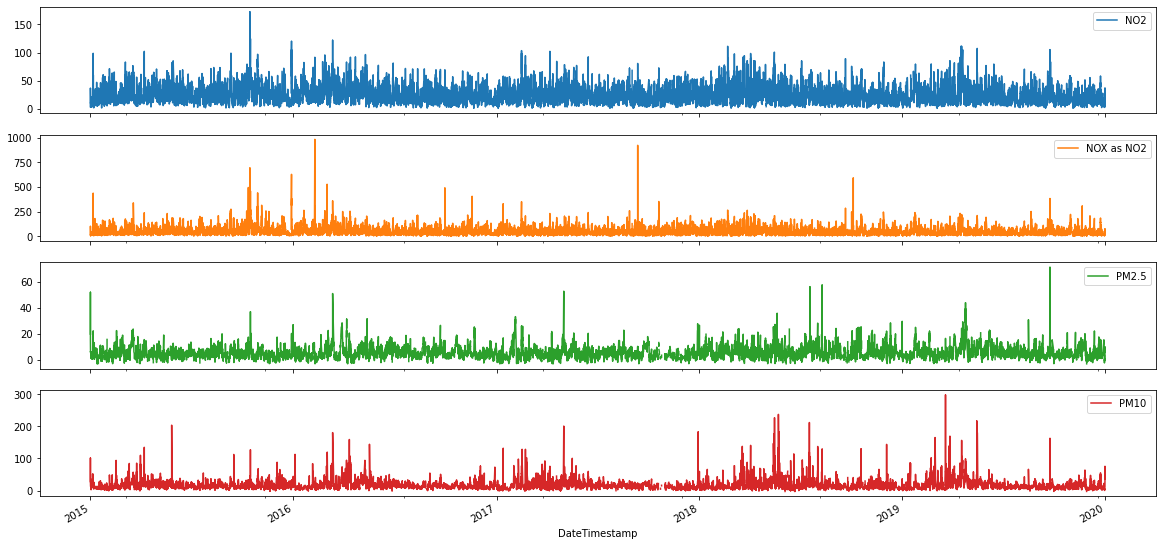

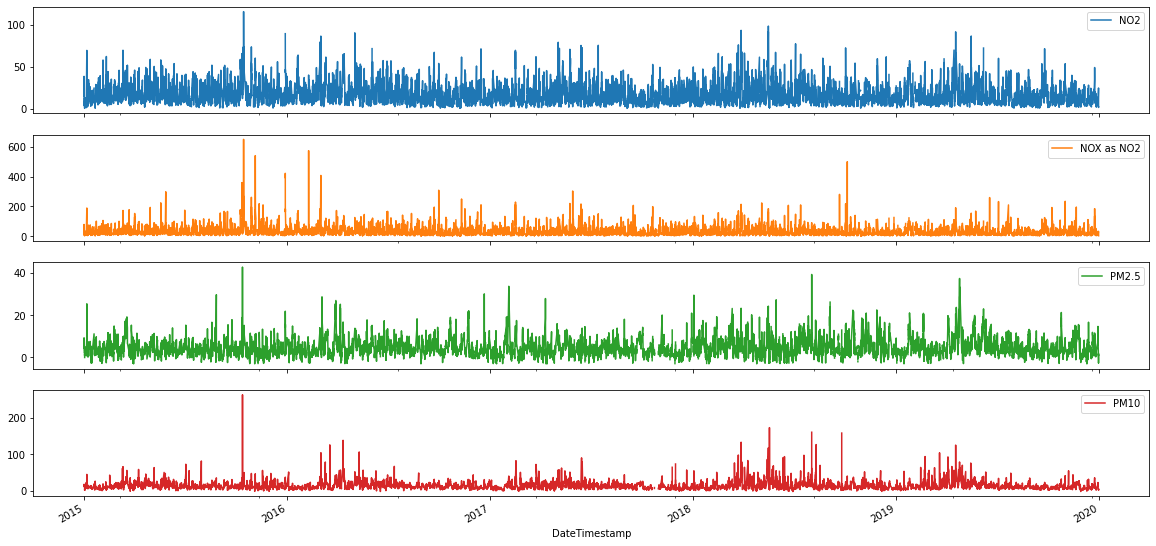

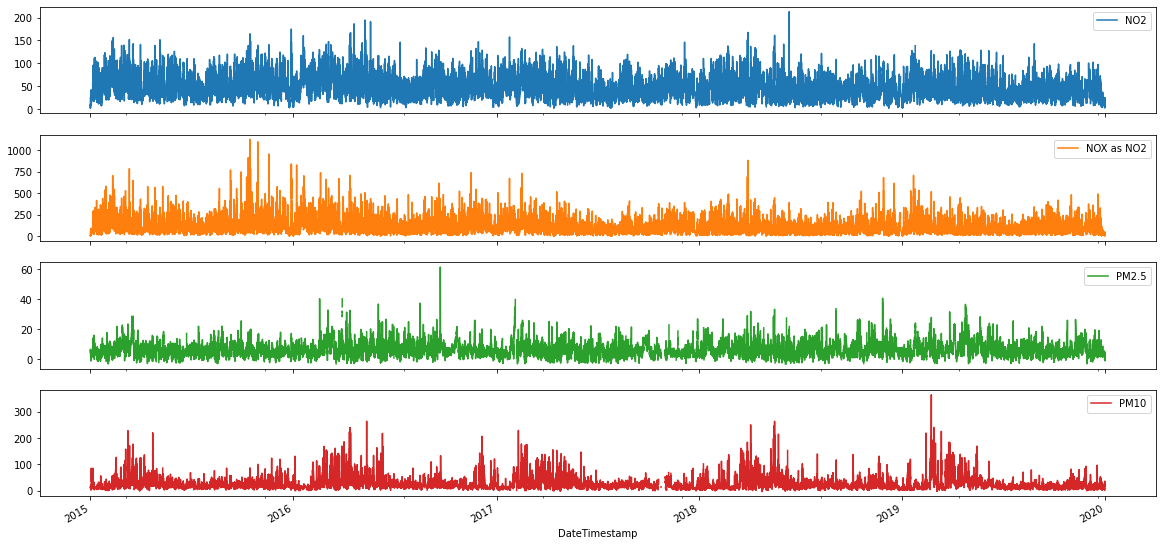

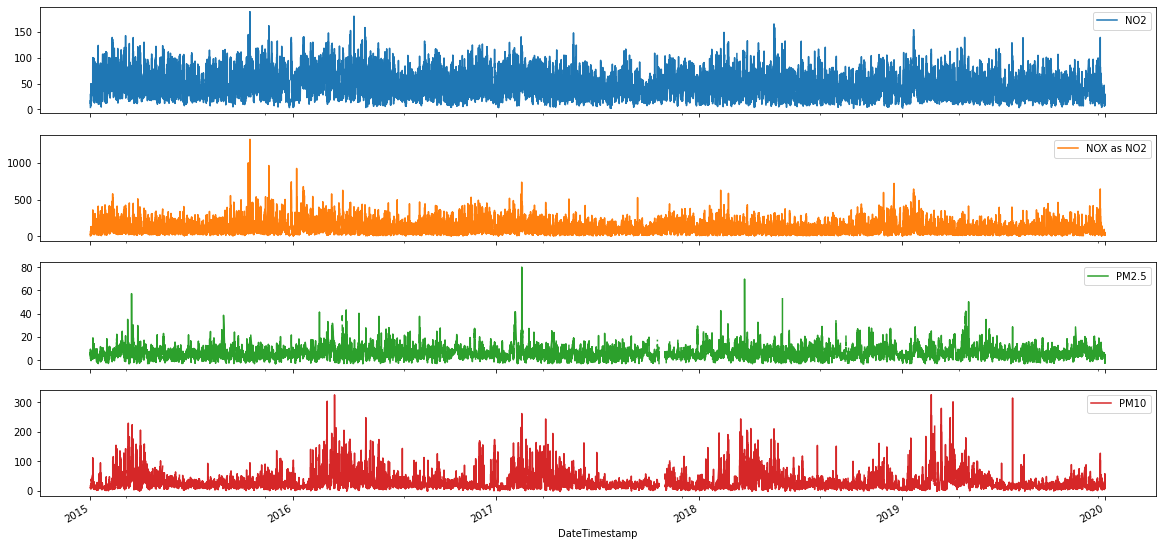

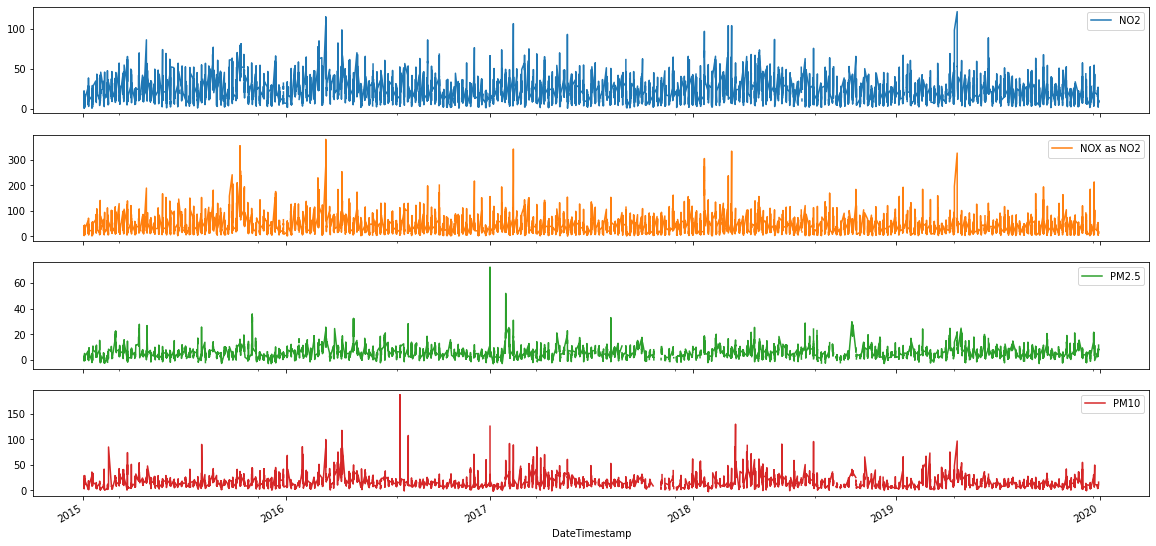

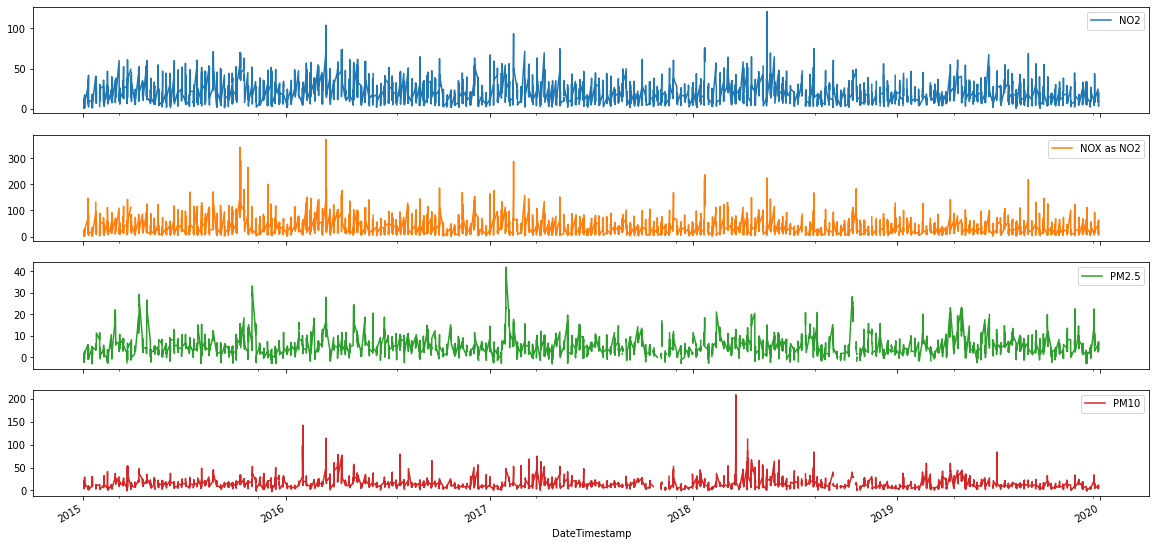

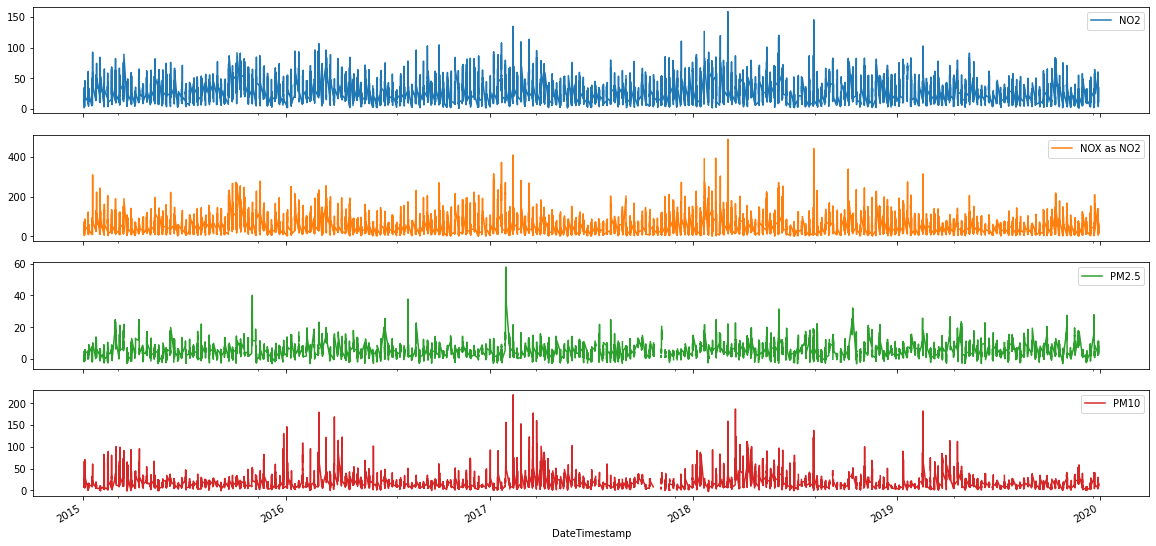

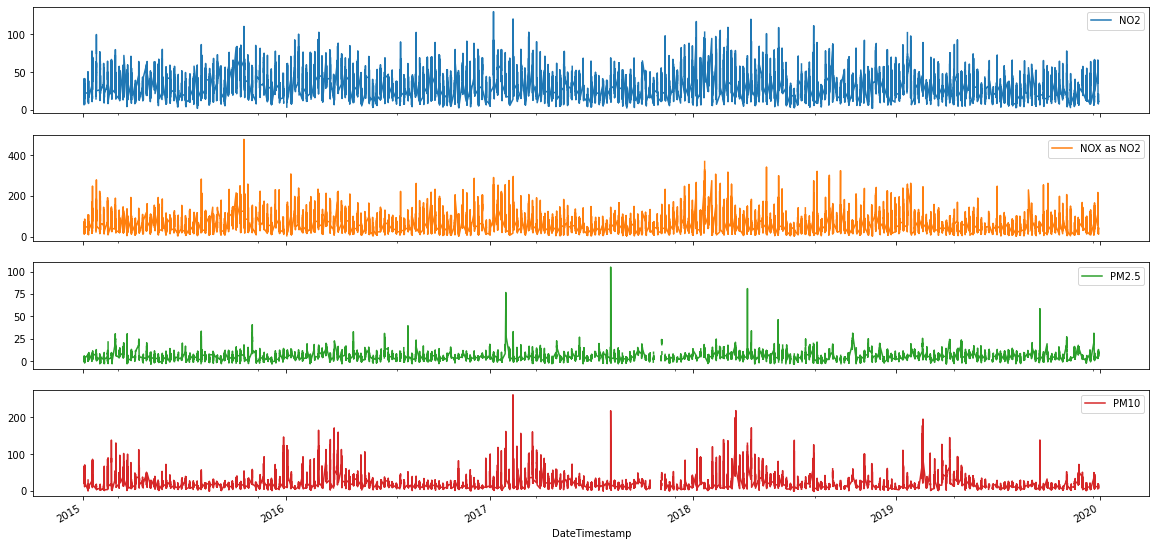

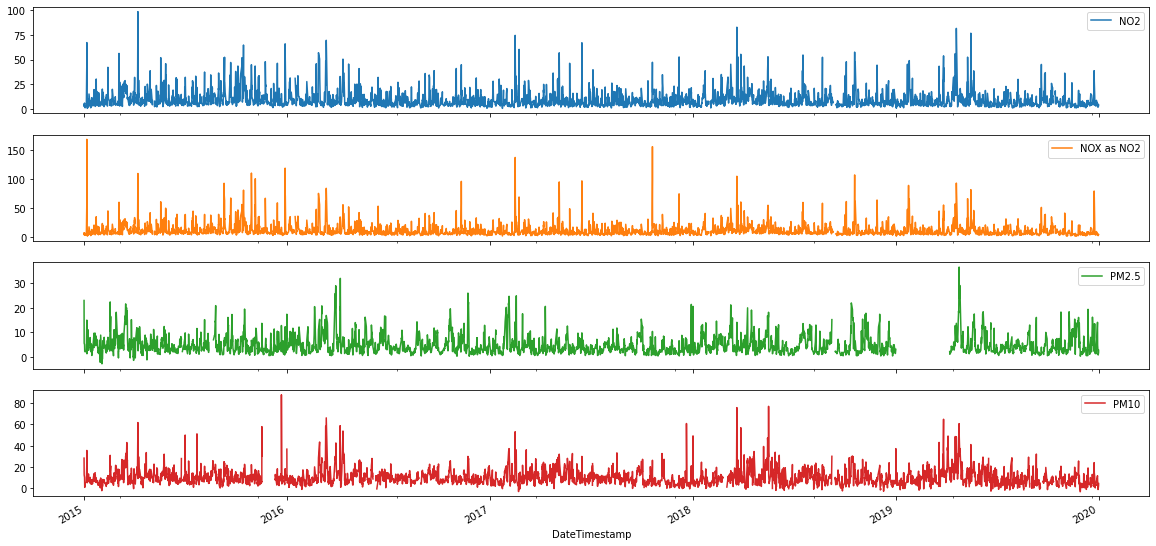

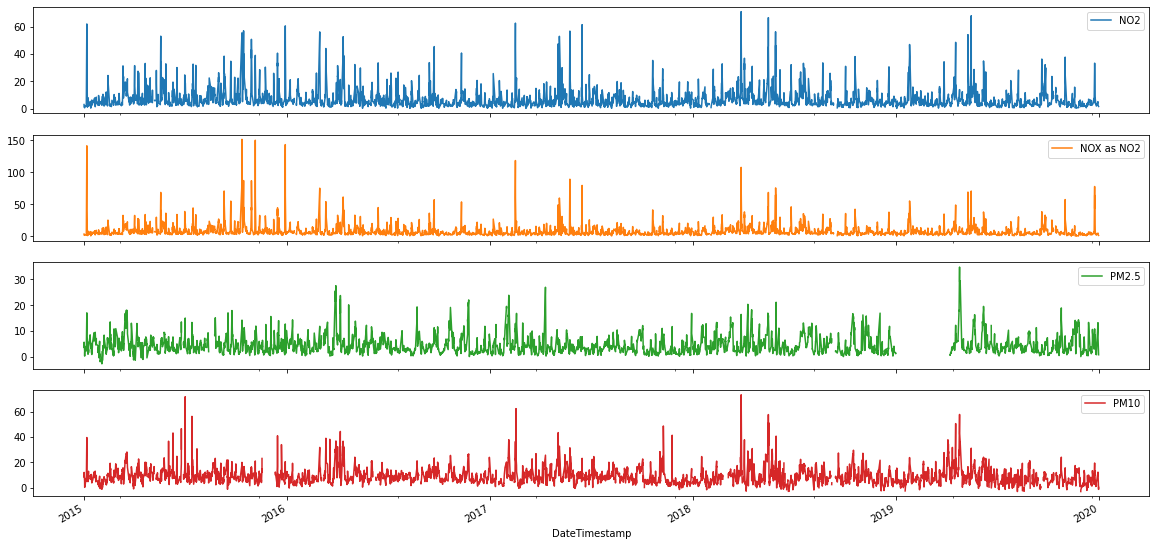

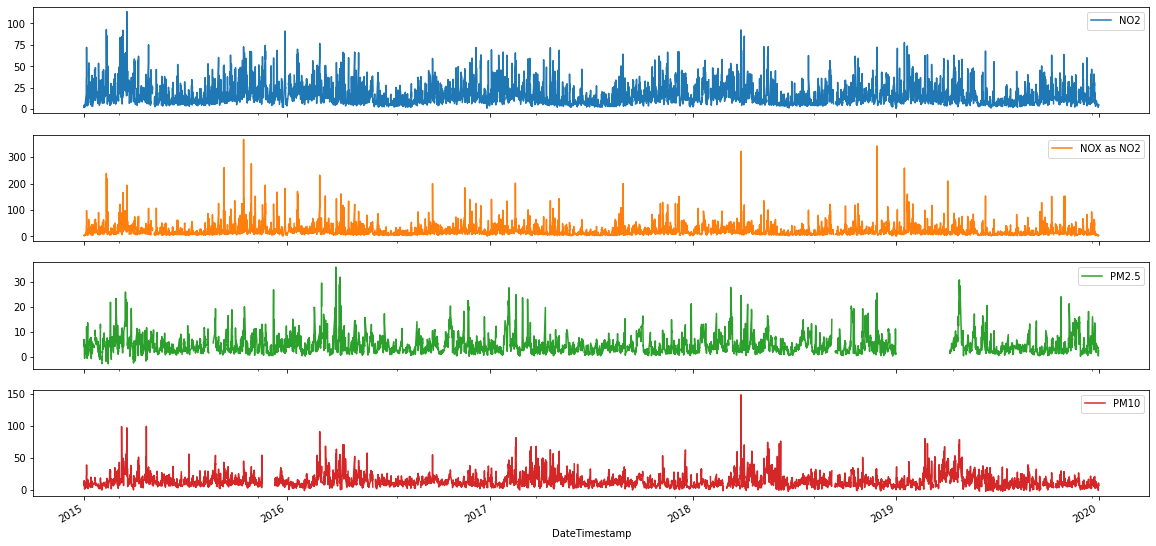

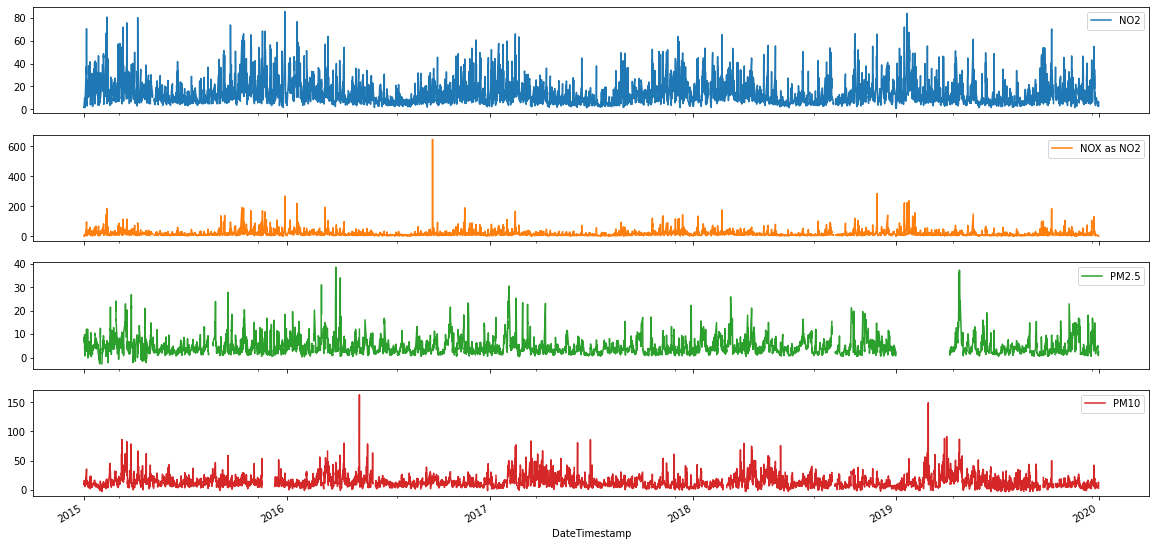

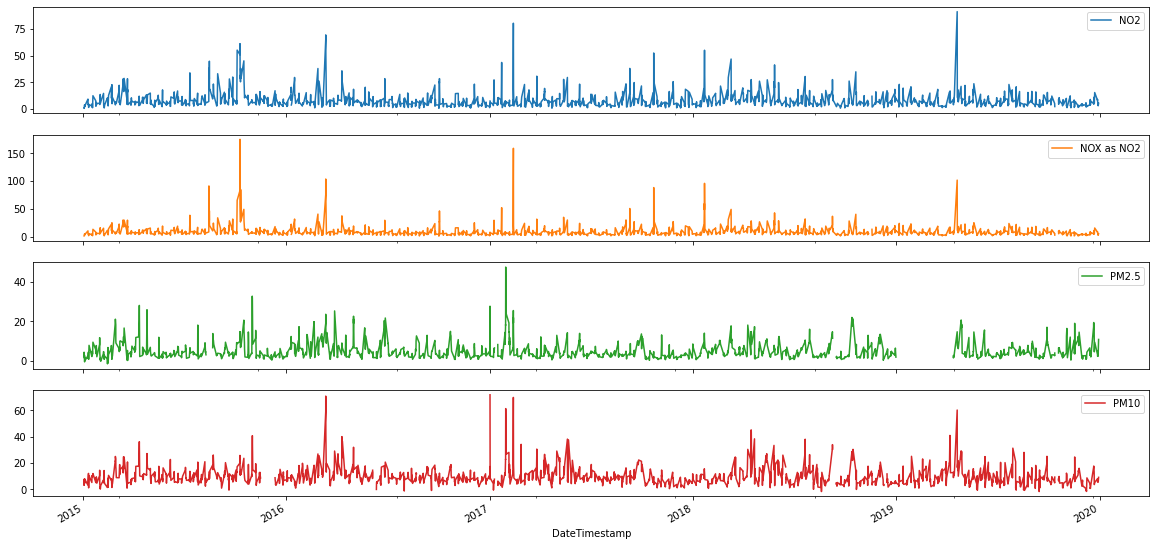

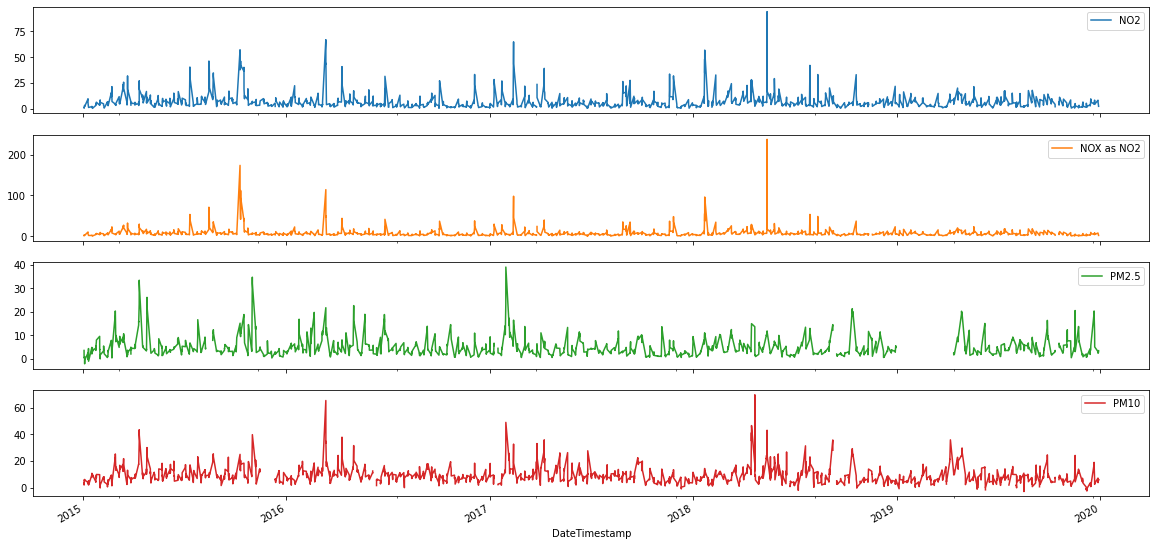

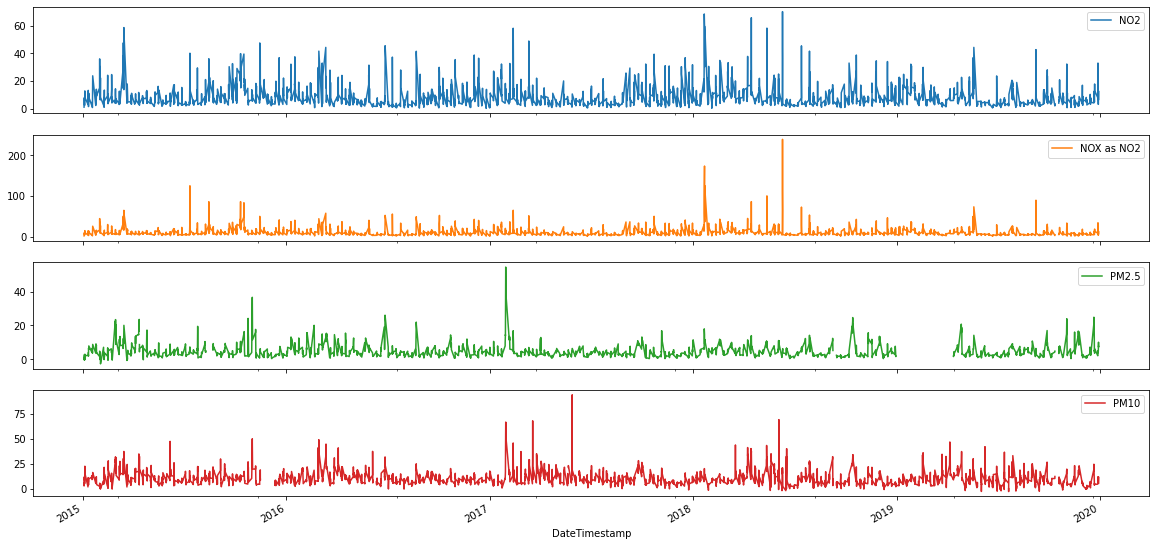

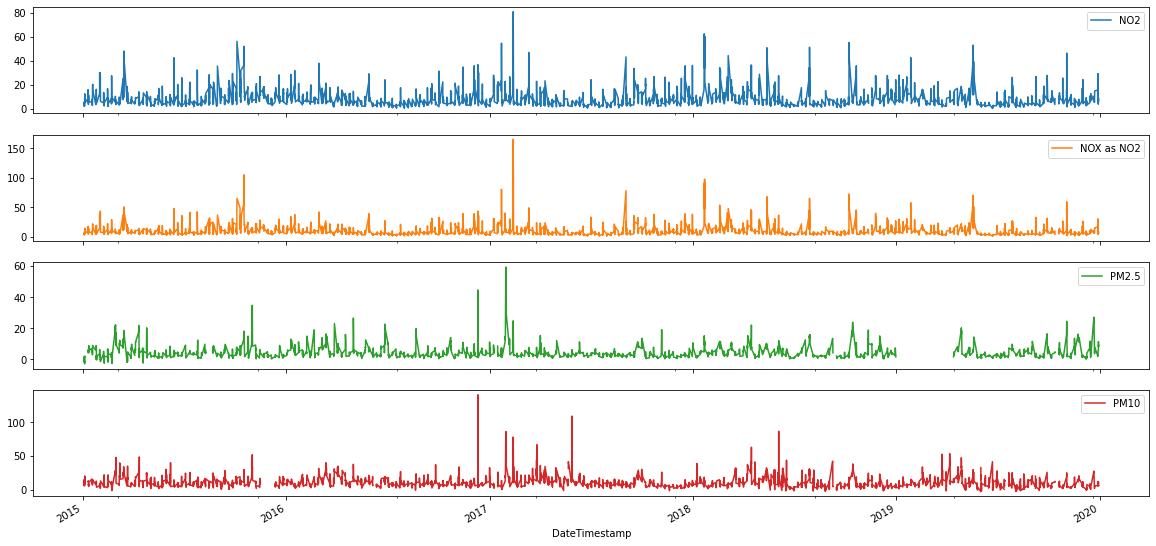

In [27]:
# Time Series before outlier removal

cfilt = list(df['Classification'].unique())
wfilt = list(df['Weektype'].unique())
hfilt = list(df['Hour'].unique())

temp = df
temp = temp.set_index("DateTimestamp")

for clvl in cfilt:
    for wlvl in wfilt:
        for hlvl in hfilt:
            print('Classification == "'+str(clvl)+'" & Weektype == "'+str(wlvl)+'" & Hour == "'+str(hlvl)+'"')
            # generate segment data
            plot_data1 = temp.query('Classification == "'+str(clvl)+'" & Weektype == "'+str(wlvl)+'" & Hour == "'+str(hlvl)+'"')
            # ploting the current segment
            plot_data1[['Station Name','Classification',
                        'Weektype','Hour','NO2', 'NOX as NO2',
                        'PM2.5', 'PM10']].plot(figsize = (20,10), subplots = True)

In [41]:
from sklearn.ensemble import IsolationForest

# remove warning
pd.set_option('mode.chained_assignment', None)

## Removing Outliers based on individual spatial classes
# replace na with zero
df_1 = df.fillna(-99)

# IsolationForest parameter
clf=IsolationForest(n_estimators=100, max_samples='auto', contamination=float(.12), \
                        max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42, verbose=1)

cfilt = list(df_1['Classification'].unique())
wfilt = list(df_1['Weektype'].unique())
hfilt = list(df_1['Hour'].unique())

df_2 = pd.DataFrame(columns = ['DateTimestamp','Station Name','Classification',
                               'Weektype','Hour','NO2', 'NOX as NO2','PM2.5', 'PM10'])

for clvl in cfilt:
    for wlvl in wfilt:
        for hlvl in hfilt:
            
            print('Classification == "'+str(clvl)+'" & Weektype == "'+str(wlvl)+'" & Hour == "'+str(hlvl)+'"')
            print(len(df_1.query('Classification == "'+str(clvl)+'" & Weektype == "'+str(wlvl)+'" & Hour == "'+str(hlvl)+'"')))
            temp = df_1.query('Classification == "'+str(clvl)+'" & Weektype == "'+str(wlvl)+'" & Hour == "'+str(hlvl)+'"')
            
            # detect Outliers
            to_model_columns=temp.columns[5:9]
            # fiting data
            clf.fit(temp[to_model_columns])
            # predicting ouliers
            pred = clf.predict(temp[to_model_columns])
            # marking outliers
            temp['anomaly'] = pred
            outliers=temp.loc[temp['anomaly']==-1]
            #outlier_index=list(outliers.index)

            # number of anomalies(-1) and normal points(1)
            print(temp['anomaly'].value_counts())
            df_2 = df_2.append(temp)
            print('Appended\n')

# columns to revert back to nan            
cols = ['NO2', 'NOX as NO2','PM2.5', 'PM10']
df_2[cols] = df_2[cols].replace( -99, np.nan )
print('\n')
print('df_2 Description:')
print(df_2.info())
print(df_2.describe())

# selecting non-anomaly 
df_3 = df_2[df_2['anomaly'] == 1]
df_3 = df_3.drop(['anomaly'],axis = 1)
print('\n')
print('df_3 Description:')
print(df_3.info())
print(df_3.describe())

# saving non anomaly data
print("Saving File")
savePath = r"G:\Uppsala Docs\period5&6\ProcessedData"
df_3.to_csv(savePath+"\\"+'2015-2019_SensorData_SelectedFourStation.csv')      

Classification == "Urban Traffic" & Weektype == "WeekDay" & Hour == "Transition"
15648


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.5s finished


 1    13770
-1     1878
Name: anomaly, dtype: int64
Appended

Classification == "Urban Traffic" & Weektype == "WeekDay" & Hour == "Night"
15648


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.4s finished


 1    13770
-1     1878
Name: anomaly, dtype: int64
Appended

Classification == "Urban Traffic" & Weektype == "WeekDay" & Hour == "Traffic"
27384


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.6s remaining:    0.6s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.6s finished


 1    24098
-1     3286
Name: anomaly, dtype: int64
Appended

Classification == "Urban Traffic" & Weektype == "WeekDay" & Hour == "Peak"
35208


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.5s finished


 1    30983
-1     4225
Name: anomaly, dtype: int64
Appended

Classification == "Urban Traffic" & Weektype == "WeekEnd" & Hour == "Transition"
6264


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.4s finished


 1    5512
-1     752
Name: anomaly, dtype: int64
Appended

Classification == "Urban Traffic" & Weektype == "WeekEnd" & Hour == "Night"
6264


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.3s finished


 1    5512
-1     752
Name: anomaly, dtype: int64
Appended

Classification == "Urban Traffic" & Weektype == "WeekEnd" & Hour == "Traffic"
10962


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.3s finished


 1    9646
-1    1316
Name: anomaly, dtype: int64
Appended

Classification == "Urban Traffic" & Weektype == "WeekEnd" & Hour == "Peak"
14094


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.3s finished


 1    12402
-1     1692
Name: anomaly, dtype: int64
Appended

Classification == "Urban Background" & Weektype == "WeekDay" & Hour == "Transition"
5216


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.3s finished


 1    4590
-1     626
Name: anomaly, dtype: int64
Appended

Classification == "Urban Background" & Weektype == "WeekDay" & Hour == "Night"
5216


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.3s finished


 1    4590
-1     626
Name: anomaly, dtype: int64
Appended

Classification == "Urban Background" & Weektype == "WeekDay" & Hour == "Traffic"
9128


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.4s finished


 1    8033
-1    1095
Name: anomaly, dtype: int64
Appended

Classification == "Urban Background" & Weektype == "WeekDay" & Hour == "Peak"
11736


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.4s finished


KeyboardInterrupt: 

In [40]:
# distribution before outlier detection
df.groupby(['Classification',
            'Weektype',
            'Hour']).aggregate(['min', np.median, 'max'])

NO2               NOX as NO2         \
                                      min median    max        min median   
Classification   Weektype Hour                                              
Urban Background WeekDay  Night       0.3    4.5   70.9        0.5    5.3   
                          Peak        0.9   10.6   85.2        1.6   13.1   
                          Traffic     0.7   13.0  113.5        1.3   15.1   
                          Transition  0.4    6.4   98.6        0.9    7.2   
                 WeekEnd  Night       0.4    4.8   94.2        0.6    5.6   
                          Peak        0.5    6.1   81.1        1.4    7.5   
                          Traffic     0.3    5.9   70.1        1.0    7.1   
                          Transition  0.3    5.9   91.3        0.9    6.8   
Urban Traffic    WeekDay  Night       0.3   13.4  116.1        0.1   20.5   
                          Peak        2.0   43.1  189.0        2.1   91.7   
                          Traffic     2.0   44.3  212.8        2.6   92.2   
                          Transition  0.8   20.9  172.8        0.9   34.1   
                 WeekEnd  Night       0.5   15.9  120.8        1.9   24.4   
                          Peak        2.0   28.1  130.1        2.8   52.1   
                          Traffic     0.6   24.0  158.8        1.3   41.0   
                          Transition  0.8   20.4  121.6        1.0   32.1   

                                             PM2.5               PM10         \
                                         max   min median    max  min median   
Classification   Weektype Hour                                                 
Urban Background WeekDay  Night        151.7  -2.7    3.5   34.7 -3.0    7.7   
                          Peak         647.0  -2.7    3.5   38.6 -2.9   11.0   
                          Traffic      367.0  -2.8    3.6   36.0 -3.0   10.9   
                          Transition   168.1  -2.9    3.6   36.5 -2.9    8.7   
                 WeekEnd  Night        237.4  -2.2    3.7   39.0 -3.0    7.9   
                          Peak         165.2  -2.8    3.3   59.3 -2.8    8.9   
                          Traffic      239.5  -2.8    3.5   54.5 -3.0    8.8   
                          Transition   175.1  -1.6    3.8   47.6 -1.8    8.5   
Urban Traffic    WeekDay  Night        649.3  -3.0    3.8   42.8 -2.9   10.4   
                          Peak        1324.0  -3.0    5.3   80.1 -2.2   20.4   
                          Traffic     1125.0  -3.0    5.5   61.6 -2.9   19.1   
                          Transition   982.5  -3.0    4.5   71.2 -3.0   13.0   
                 WeekEnd  Night        371.8  -3.0    4.4   42.0 -2.3   11.7   
                          Peak         477.7  -3.0    4.6  105.0 -1.8   15.6   
                          Traffic      488.6  -3.0    4.6   57.8 -2.5   13.6   
                          Transition   379.9  -3.0    4.9   72.4 -2.2   13.1   

                                             
                                        max  
Classification   Weektype Hour               
Urban Background WeekDay  Night        73.3  
                          Peak        162.6  
                          Traffic     148.0  
                          Transition   87.7  
                 WeekEnd  Night        69.6  
                          Peak        140.4  
                          Traffic      94.0  
                          Transition   71.8  
Urban Traffic    WeekDay  Night       264.0  
                          Peak        324.8  
                          Traffic     365.1  
                          Transition  297.9  
                 WeekEnd  Night       208.1  
                          Peak        261.6  
                          Traffic     219.0  
                          Transition  186.8

In [39]:
# distribution after outlier detection
df_3.groupby(['Classification',
              'Weektype',
              'Hour']).aggregate(['min', np.median, 'max'])

NO2               NOX as NO2         \
                                      min median    max        min median   
Classification   Weektype Hour                                              
Urban Background WeekDay  Night       0.3    4.3   31.4        0.7    5.1   
                          Peak        1.5   10.1   51.3        1.6   12.5   
                          Traffic     0.9   12.5   60.0        1.7   14.5   
                          Transition  0.4    6.2   42.7        0.9    7.0   
                 WeekEnd  Night       0.4    4.5   28.4        0.6    5.4   
                          Peak        0.6    5.8   29.6        1.5    7.3   
                          Traffic     0.3    5.7   31.9        1.0    6.8   
                          Transition  0.3    5.7   29.8        0.9    6.6   
Urban Traffic    WeekDay  Night       0.3   12.8   51.9        0.8   19.7   
                          Peak        2.0   42.0  110.5        2.1   88.8   
                          Traffic     2.0   43.0  123.6        2.6   88.6   
                          Transition  0.8   20.1   62.9        0.9   32.5   
                 WeekEnd  Night       0.5   15.2   56.8        1.9   22.9   
                          Peak        2.0   27.3   76.7        2.8   50.2   
                          Traffic     0.6   22.9   75.2        1.3   38.8   
                          Transition  0.8   19.3   65.9        1.0   30.3   

                                            PM2.5              PM10         \
                                        max   min median   max  min median   
Classification   Weektype Hour                                               
Urban Background WeekDay  Night        36.0  -2.7   3.40  26.9 -3.0    7.5   
                          Peak         78.6  -2.7   3.40  27.8 -2.9   10.7   
                          Traffic     118.5  -2.8   3.60  24.1 -3.0   10.6   
                          Transition   45.0  -2.9   3.50  22.3 -2.9    8.4   
                 WeekEnd  Night        29.9  -2.2   3.60  22.0 -3.0    7.7   
                          Peak         36.8  -2.8   3.25  27.2 -2.8    8.7   
                          Traffic      42.3  -2.8   3.40  24.8 -3.0    8.6   
                          Transition   31.6  -1.6   3.70  22.0 -1.8    8.2   
Urban Traffic    WeekDay  Night       115.0  -3.0   3.60  24.7 -2.9   10.0   
                          Peak        370.4  -3.0   5.10  37.6 -2.2   19.8   
                          Traffic     383.4  -3.0   5.30  24.4 -2.9   18.4   
                          Transition  156.0  -3.0   4.30  22.9 -3.0   12.5   
                 WeekEnd  Night       127.9  -3.0   4.20  23.3 -1.3   11.2   
                          Peak        200.3  -3.0   4.40  26.8 -0.9   14.9   
                          Traffic     174.3  -3.0   4.40  25.3 -0.9   13.1   
                          Transition  131.0  -3.0   4.60  22.6 -1.7   12.4   

                                             
                                        max  
Classification   Weektype Hour               
Urban Background WeekDay  Night        50.7  
                          Peak         86.0  
                          Traffic      75.6  
                          Transition   36.2  
                 WeekEnd  Night        69.6  
                          Peak        108.9  
                          Traffic      94.0  
                          Transition   38.3  
Urban Traffic    WeekDay  Night        55.1  
                          Peak        125.7  
                          Traffic     115.6  
                          Transition   77.8  
                 WeekEnd  Night        49.2  
                          Peak        104.1  
                          Traffic      92.4  
                          Transition   61.0

Classification == "Urban Traffic" & Weektype == "WeekDay" & Hour == "Transition"


array([<AxesSubplot:xlabel='DateTimestamp'>,
       <AxesSubplot:xlabel='DateTimestamp'>,
       <AxesSubplot:xlabel='DateTimestamp'>,
       <AxesSubplot:xlabel='DateTimestamp'>,
       <AxesSubplot:xlabel='DateTimestamp'>,
       <AxesSubplot:xlabel='DateTimestamp'>,
       <AxesSubplot:xlabel='DateTimestamp'>], dtype=object)

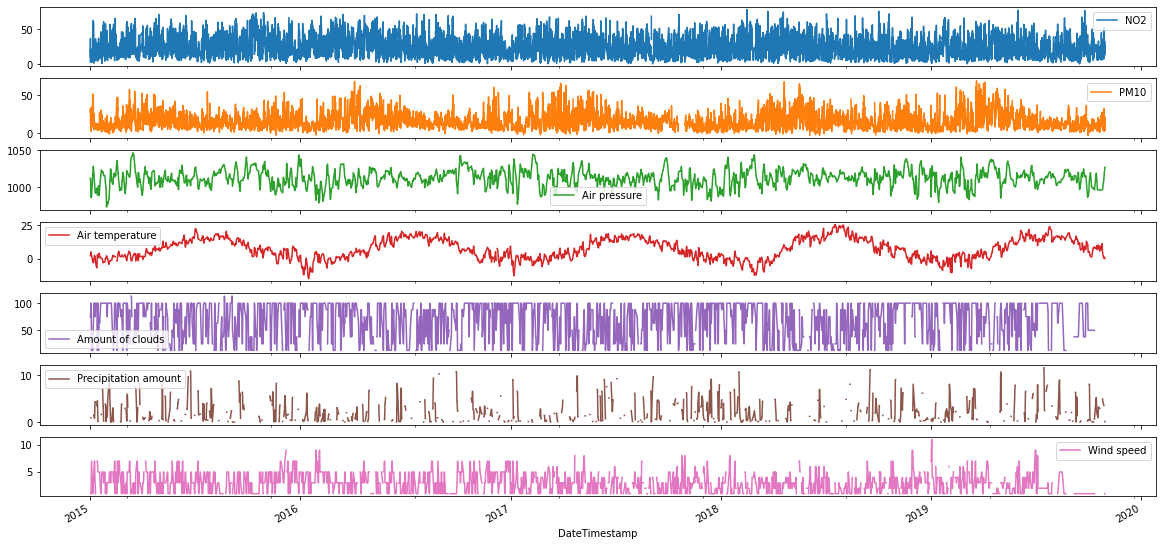

In [47]:
# Time Series after outlier removal
temp = df_3.query('Classification == "'+str(cfilt[0])+'" & Weektype == "'+str(wfilt[0])+'" & Hour == "'+str(hfilt[0])+'"')
print('Classification == "'+str(cfilt[0])+'" & Weektype == "'+str(wfilt[0])+'" & Hour == "'+str(hfilt[0])+'"')
plot_data1 = temp[['DateTimestamp','NO2','PM10','Air pressure','Air temperature',
                   'Amount of clouds', 'Precipitation amount','Wind speed']]
plot_data1 = plot_data1.set_index("DateTimestamp")
plot_data1.plot(figsize = (20,10), subplots = True)

In [48]:
## onehot encoding catergories column
# Get dummies
df_4 = pd.get_dummies(df_3)
print(df_4.info())
print(df_4.describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 154257 entries, 5 to 433463
Data columns (total 36 columns):
 #   Column                                         Non-Null Count   Dtype         
---  ------                                         --------------   -----         
 0   DateTimestamp                                  154257 non-null  datetime64[ns]
 1   NO2                                            152968 non-null  float64       
 2   PM10                                           148881 non-null  float64       
 3   Air pressure                                   154257 non-null  float64       
 4   Air temperature                                153708 non-null  float64       
 5   Amount of clouds                               146918 non-null  float64       
 6   Precipitation amount                           63529 non-null   float64       
 7   Wind speed                                     142902 non-null  float64       
 8   Station Name_#Stockholm E4/E20 Lilla Essinge

In [49]:
# No of zeros, negative and null rows
print('\nNo of Zeros Entries:\n',(df_4.iloc[:,1:35] == 0).astype(int).sum(axis=0))
print('\nNo of negative Entries:\n',(df_4.iloc[:,1:35] < 0).astype(int).sum(axis=0))
print('\nNo of null Entries:\n',(df_4.iloc[:,1:35].isnull()).astype(int).sum(axis=0))
# drop negative rows
df_4 = df_4[~(df_4.iloc[:,1:35] < 0).any(1)]
# drop nan rows
df_4 = df_4[~(df_4.iloc[:,1:35].isnull()).any(1)]
print(df_4.info())
print(df_4.describe())
print(df_4.columns)


No of Zeros Entries:
 NO2                                                   0
PM10                                                  0
Air pressure                                          0
Air temperature                                       0
Amount of clouds                                      0
Precipitation amount                                  0
Wind speed                                            0
Station Name_#Stockholm E4/E20 Lilla Essingen    115759
Station Name_#Stockholm Hornsgatan 108 Gata      116101
Station Name_#Stockholm Sveavägen 59 Gata        115218
Station Name_#Stockholm Torkel Knutssongatan     115693
Classification_Urban Background                  115693
Classification_Urban Traffic                      38564
Weektype_WeekDay                                  44096
Weektype_WeekEnd                                 110161
Hour_Night                                       128547
Hour_Peak                                         96410
Hour_Traffic             

None
                NO2          PM10  Air pressure  Air temperature  \
count  47025.000000  47025.000000  47025.000000     47025.000000   
mean      27.118497     15.130258   1006.129669         8.658975   
std       21.086634     12.598784     10.616280         6.231242   
min        0.300000      0.100000    970.600000         0.100000   
25%       10.000000      7.300000    999.300000         3.300000   
50%       21.600000     11.800000   1007.300000         7.600000   
75%       39.400000     18.700000   1013.000000        13.800000   
max      180.200000    122.100000   1044.400000        31.200000   

       Amount of clouds  Precipitation amount    Wind speed  \
count      47025.000000          47025.000000  47025.000000   
mean          79.923934              2.438752      3.289867   
std           28.097020              2.588163      1.893043   
min           13.000000              0.100000      1.000000   
25%           63.000000              0.400000      2.000000   
50% 

In [51]:
# Generating Year
df_4['Year'] = df_4['DateTimestamp'].dt.year

# dropping 2020 data
df_4 = df_4[df_4['Year'] != 2020]

# defining the length of the train and test 
train_len = df_4.loc[df_4['Year'].isin([2015,2016,2017,2018])].shape[0]
print('Train:',df_4.loc[df_4['Year'].isin([2015,2016,2017,2018])].shape[0])
print('Test: ',df_4.loc[df_4['Year'] ==  2019].shape[0])

Train: 40204
Test:  6821


In [76]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

## Modyfying data for training LSTM 

# selecting PM10 column
data_set  = df_4.iloc[:,1:35].values
data_set  = data_set.reshape(-1,34)
print("Data Set:\n",data_set[0])
print("Shape:\n",data_set.shape)
print()

# Normalisation of Data
sc = MinMaxScaler(feature_range = (0, 1))
data_set_scaled = sc.fit_transform(data_set)
print("Normalised Data Set:\n",data_set_scaled[0])
print()

# Generating Features and predictions
X = data_set_scaled[0:len(data_set_scaled)-1,:]
y = data_set_scaled[1:len(data_set_scaled),1] # PM10 index 1 

print("X:\n",X[0:3])
print("X Shape:\n",X.shape)
print()
print("Y:\n",y[0:3])
print("Y Shape:\n",y.shape)

Data Set:
 [  5.4  11.1 986.    5.2 100.    1.    1.    1.    0.    0.    0.    0.
   1.    1.    0.    0.    0.    0.    1.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    1.    0. ]
Shape:
 (47025, 34)

Normalised Data Set:
 [0.02834908 0.09016393 0.20867209 0.16398714 1.         0.05487805
 0.         1.         0.         0.         0.         0.
 1.         1.         0.         0.         0.         0.
 1.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         1.         0.        ]

X:
 [[0.02834908 0.09016393 0.20867209 0.16398714 1.         0.05487805
  0.         1.         0.         0.         0.         0.
  1.         1.         0.         0.         0.         0.
  1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         1.         0.        ]
 [0.05780989 0.09672131 0.20867

In [88]:
# generate object to inverse transform the predicted data
print(data_set_scaled[0:len(data_set_scaled)-1,1])
print(data_set[0:len(data_set)-1,1])
i_sc = MinMaxScaler(feature_range = (0, 1))
print(i_sc.fit_transform(data_set[:,1].reshape(-1, 1)))

[0.09016393 0.09672131 0.09098361 ... 0.09180328 0.09016393 0.09344262]
[11.1 11.9 11.2 ... 11.3 11.1 11.5]
[[0.09016393]
 [0.09672131]
 [0.09098361]
 ...
 [0.09016393]
 [0.09344262]
 [0.09672131]]


In [89]:
## splitting data into test and train
X_train = X[0:train_len]
y_train = y[0:train_len]
X_test = X[train_len+1:len(X)]
y_test = y[train_len+1:len(X)]

# reshape input to be 3D [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

print("X_train_shape:\n",X_train.shape)
print("y_train_shape:\n",y_train.shape)
print("X_test_shape:\n",X_test.shape)
print("y_test_shape:\n",y_test.shape)

X_train_shape:
 (40204, 1, 34)
y_train_shape:
 (40204,)
X_test_shape:
 (6819, 1, 34)
y_test_shape:
 (6819,)


In [96]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
# from keras.layers import Masking
# model.add(Masking(mask_value=-1,input_shape = (X.shape[1], 1)))

## LSTM Architecture
# input layer
model = Sequential()
# 1
model.add(LSTM(units = 10,input_shape = (X_train.shape[1], X_train.shape[2]),return_sequences = False))
# output layer
model.add(Dense(units = 1))
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 10)                1800      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 1,811
Trainable params: 1,811
Non-trainable params: 0
_________________________________________________________________


In [1]:
# Compile LSTM Model
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
# Train the model on the data
history = model.fit(X_train, y_train, epochs = 100,batch_size = 32, validation_split=0.33)

NameError: name 'model' is not defined

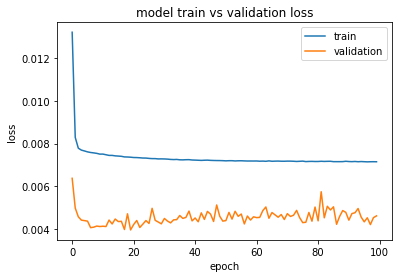

In [92]:
from matplotlib import pyplot
# plot train and validation loss
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

In [93]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# predicting PM10
predicted_y = model.predict(X_test)

# De-normalising predicted y data
predicted_y = i_sc.inverse_transform(predicted_y)
# De-normalising actual y data
y_actual = i_sc.inverse_transform(y_test.reshape(-1,1))

# calculating RMSE
rmse = sqrt(mean_squared_error(y_actual.reshape(-1,1), predicted_y))
rmse

8.526472403050802

In [94]:
print('Actual values: \n',y_actual.reshape(-1,1)[0:15])
print('Predicted values: \n',predicted_y[0:15])

Actual values: 
 [[ 7.8]
 [17.1]
 [14. ]
 [14. ]
 [10.9]
 [11.1]
 [14.8]
 [10.3]
 [ 4.5]
 [ 3.4]
 [ 5.8]
 [ 4.2]
 [16.4]
 [15.2]
 [15. ]]
Predicted values: 
 [[13.489159]
 [13.493379]
 [18.286198]
 [16.6884  ]
 [17.003767]
 [15.888583]
 [20.374035]
 [22.090193]
 [19.826529]
 [16.769844]
 [16.214016]
 [17.405045]
 [16.59232 ]
 [24.063946]
 [23.134823]]


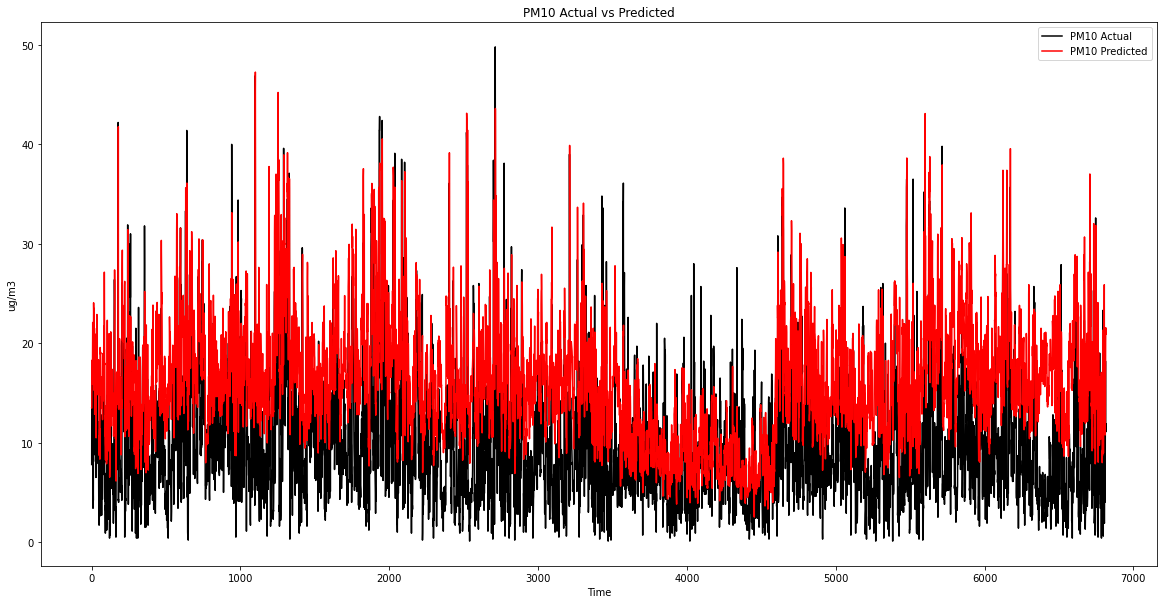

In [95]:
plt.figure(figsize=(20,10))
plt.plot(y_actual, color = 'black', label = 'PM10 Actual')
plt.plot(predicted_y, color = 'red', label = 'PM10 Predicted')
plt.title('PM10 Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('ug/m3')
plt.legend()
plt.show()